<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/AutoEncoder_Vanilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Autoencoders

This material is based on [Intro to Autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder) and may be copyrighted by the original writers. For educational uses only.

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashon MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## Basic autoencoder
![Basic autoencoder results](https://www.tensorflow.org/tutorials/generative/images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [26]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()

    self.latent_dim = latent_dim
    self.start = tf.keras.layers.Flatten(input_shape = (28,28))
    #Encoder
    self.layer1 = tf.keras.layers.Dense(latent_dim*2, activation = 'relu')
    #Latent Space
    self.layer2 = tf.keras.layers.Dense(latent_dim, activation = 'relu')
    #Decoder
    self.layer3 = tf.keras.layers.Dense(latent_dim*2, activation = 'sigmoid')
    self.out = tf.keras.layers.Dense(784)
    self.reshapes = tf.keras.layers.Reshape((28,28))

  def call(self, x):
    # Inference 
    x = self.start(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.out(x)
    x = self.reshapes(x)

    return x
  
autoencoder = Autoencoder(latent_dim) 
'''
print('\nEncoder')
autoencoder.encoder.summary()

print('\nDecoder')
autoencoder.decoder.summary()
'''

"\nprint('\nEncoder')\nautoencoder.encoder.summary()\n\nprint('\nDecoder')\nautoencoder.decoder.summary()\n"

In [27]:
# define optimizer and compile

autoencoder = Autoencoder(latent_dim)
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.01)
autoencoder.compile(optimizer = optimizer, loss = loss_object)


Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [28]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 9s 3ms/step - loss: 0.0267 - val_loss: 0.0219
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0208 - val_loss: 0.0199
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0195 - val_loss: 0.0188
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0190 - val_loss: 0.0185
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0186 - val_loss: 0.0193
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0183 - val_loss: 0.0195
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0182 - val_loss: 0.0188
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0180 - val_loss: 0.0196
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0179 - val_loss: 0.0184
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.017

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [31]:
# Reconstruct test images
################ Implementation ################

x = autoencoder.start(x_test)
x = autoencoder.layer1(x)
x = autoencoder.layer2(x)
x = autoencoder.layer3(x)
x = autoencoder.out(x)
x = autoencoder.reshapes(x)
decoded_imgs = x
'''
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
################ Implementation ################
'''

'\nencoded_imgs = autoencoder.encoder(x_test).numpy()\ndecoded_imgs = autoencoder.decoder(encoded_imgs).numpy()\n################ Implementation ################\n'

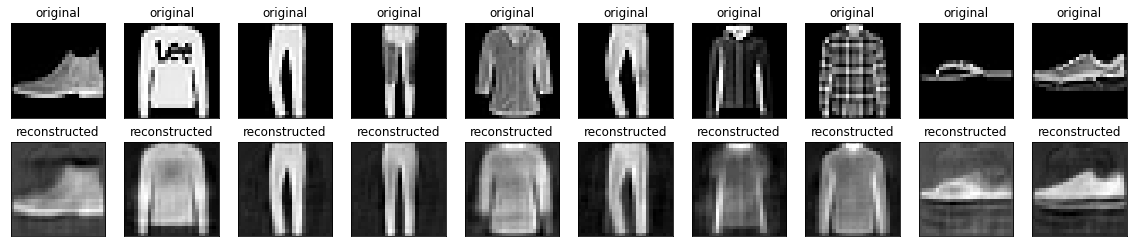

In [32]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# T-SNE 

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

def plot_tsne(inputs, labels):
  n_samples = len(labels)
  tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
  tsne_features = tsne.fit_transform(inputs[:n_samples].reshape(n_samples, -1))
  df = pd.DataFrame({
      'x': tsne_features[:,0],
      'y': tsne_features[:,1],
      'label': labels[:n_samples]
  })

  sns.scatterplot(data=df, x='x', y='y', hue='label', palette="deep")

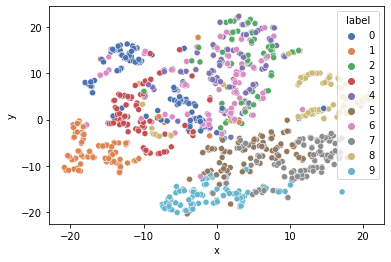

In [ ]:
n_samples = 1000
plot_tsne(x_train[:n_samples], y_train[:n_samples])

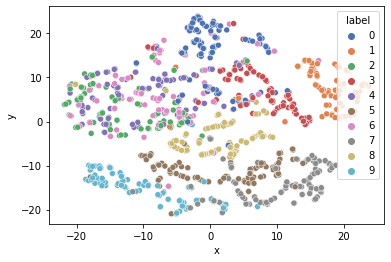

In [ ]:
z_train = autoencoder.encoder(x_train[:n_samples]).numpy()
plot_tsne(z_train, y_train[:n_samples])